In [21]:
cd /content/drive/MyDrive/Colab Notebooks/cells

/content/drive/MyDrive/Colab Notebooks/cells


In [22]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import mmread


class RNA(Dataset):
    def __init__(self, data_file):
        # load the scRNA-seq data from the specified file
        self.data = torch.from_numpy(
            mmread(data_file).astype("float32").transpose().todense())
        print(self.data.shape)
        
    def __len__(self):
        # return the number of examples in the dataset
        return len(self.data)
    
    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        library = self.data[index].sum(dim=-1)
        example = self.data[index]
        return example, library

        

# datasets: hcl, celegan, uc_epi, zfish_ep50_5226
# train_dataset = RNA("cells/data/hcl.mtx")
# train_dataset = RNA("data/zfish_ep50_5226.mtx")
train_dataset = RNA("cells/data/celegan.mtx")
train_loader = DataLoader(train_dataset, batch_size=2**12, shuffle=True) # 2**15


torch.Size([86024, 2766])


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# ---------------------------
# - Variational Autoencoder -
# ---------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2) # mu + log_var
        )
        
        self.decoder = self.decode = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim))
        
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

    def loss(self, x, x_hat, mu, log_var):
        recon_loss = F.mse_loss(x_hat, x, reduction="sum")
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss, kl_div


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vae = VAE(input_dim=next(iter(train_loader))[0].shape[-1], latent_dim=2).to(dev)
vae_opt = optim.Adam(vae.parameters(), lr=1e-3)
vae.train()
opt = optim.Adam(vae.parameters())

In [25]:
def train_vae(model, opt, train_loader, num_epochs, kl_weight=4):
    loss_history = {'train_loss': [], 'recon_loss': [], 'kl_loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        for _, (data, library) in enumerate(train_loader):
            data = data.to(dev)
            library = library.to(dev)
            opt.zero_grad()
            x_hat, mu, log_var = model(data)
            x_hat = F.softmax(x_hat, dim=-1) * library.unsqueeze(-1)
            recon_loss, kl_div = model.loss(data, x_hat, mu, log_var)
            loss = recon_loss + kl_weight * kl_div
            loss.backward()
            opt.step()

            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_div.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
        epoch_kl_loss = running_kl_loss / len(train_loader.dataset)
        loss_history['train_loss'].append(epoch_loss)
        loss_history['recon_loss'].append(epoch_recon_loss)
        loss_history['kl_loss'].append(epoch_kl_loss)
        print(f"Epoch: {epoch}, Loss: {epoch_loss}, Recon Loss: {epoch_recon_loss}, KL Loss: {epoch_kl_loss}")
    
    return loss_history

vae_loss_hist = train_vae(vae, vae_opt, train_loader, 200)

Epoch: 0, Loss: 28354.178428403702, Recon Loss: 27560.361446369618, KL Loss: 198.45422499427949
Epoch: 1, Loss: 23045.431315985854, Recon Loss: 23027.481218427234, KL Loss: 4.4875381592538846
Epoch: 2, Loss: 22459.355449496652, Recon Loss: 22441.743319542365, KL Loss: 4.40300959107555
Epoch: 3, Loss: 22070.729127599927, Recon Loss: 22055.051719305804, KL Loss: 3.9194166653878875
Epoch: 4, Loss: 22835.11803805297, Recon Loss: 22811.41565191155, KL Loss: 5.92559358444334
Epoch: 5, Loss: 23080.36002094074, Recon Loss: 23067.3829270665, KL Loss: 3.24427040339647
Epoch: 6, Loss: 24150.095748261385, Recon Loss: 24137.9549168328, KL Loss: 3.0352286959896198
Epoch: 7, Loss: 22695.07529539358, Recon Loss: 22681.942664619757, KL Loss: 3.2831262320925845
Epoch: 8, Loss: 22486.518312612978, Recon Loss: 22471.37478408097, KL Loss: 3.7858622834414843
Epoch: 9, Loss: 23279.322440358213, Recon Loss: 23257.278831888485, KL Loss: 5.510917569475041
Epoch: 10, Loss: 23638.441156932768, Recon Loss: 23624.6

In [26]:
# Calculate reconstruction loss on "test" subset
vae.eval()
test, test_lib = next(iter(DataLoader(train_dataset, batch_size=200, shuffle=False)))
test, test_lib = test.to(dev), test_lib.to(dev)
with torch.no_grad():
    x_hat, mu, log_var,= vae(test)
    x_hat = F.softmax(x_hat, dim=-1) * test_lib.unsqueeze(-1)
    loss = F.mse_loss(x_hat, test, reduction='mean')
    print(f"Reconstruction loss: {loss.item():.4f}")

Reconstruction loss: 2.0693


In [27]:
# ------------------------
# - Gaussian Mixture VAE -
# ------------------------
from torchinfo import summary

class GMVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_clusters):
        super(GMVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.K = num_clusters
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim*num_clusters*2)
        )
        
        self.decoder = self.decode = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        mu = mu.view(-1, self.K, self.latent_dim)
        log_var = log_var.view(-1, self.K, self.latent_dim)
        return mu, log_var

    def reparameterize(self, mu, log_var, temperature=1.0):
        eps = torch.randn_like(log_var)
        z = mu + torch.exp(log_var / 2) * eps
        # Gumbel-Softmax trick 
        gumbel_softmax_logits = (z.view(-1, self.K, self.latent_dim) / temperature).softmax(dim=-1) # (B, K, latent_dim)
        z = (gumbel_softmax_logits * z.view(-1, self.K, self.latent_dim)).sum(dim=1) # (B, latent_dim)
        return z, gumbel_softmax_logits


    def forward(self, x, temperature=1.0):
        x = x.view(-1, self.input_dim)
        mu, log_var = self.encode(x)
        z, gumbel_softmax_logits = self.reparameterize(mu, log_var, temperature=temperature)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, z, gumbel_softmax_logits

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gm = GMVAE(input_dim=next(iter(train_loader))[0].shape[-1], latent_dim=2, num_clusters=5).to(dev)
gm_opt = optim.Adam(gm.parameters(), lr=1e-3, weight_decay=1e-5)
gm.train()
summary(gm, input_size=(2**12, 2766), device=dev)

Layer (type:depth-idx)                   Output Shape              Param #
GMVAE                                    [4096, 2766]              --
├─Sequential: 1-1                        [4096, 20]                --
│    └─Linear: 2-1                       [4096, 512]               1,416,704
│    └─ReLU: 2-2                         [4096, 512]               --
│    └─Linear: 2-3                       [4096, 256]               131,328
│    └─ReLU: 2-4                         [4096, 256]               --
│    └─Linear: 2-5                       [4096, 20]                5,140
├─Sequential: 1-2                        [4096, 2766]              --
│    └─Linear: 2-6                       [4096, 256]               768
│    └─ReLU: 2-7                         [4096, 256]               --
│    └─Linear: 2-8                       [4096, 512]               131,584
│    └─ReLU: 2-9                         [4096, 512]               --
│    └─Linear: 2-10                      [4096, 2766]           

In [28]:
summary(vae, input_size=(2**12, 2766), device=dev)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [4096, 2766]              --
├─Sequential: 1-1                        [4096, 4]                 --
│    └─Linear: 2-1                       [4096, 512]               1,416,704
│    └─ReLU: 2-2                         [4096, 512]               --
│    └─Linear: 2-3                       [4096, 256]               131,328
│    └─ReLU: 2-4                         [4096, 256]               --
│    └─Linear: 2-5                       [4096, 4]                 1,028
├─Sequential: 1-2                        [4096, 2766]              --
│    └─Linear: 2-6                       [4096, 256]               768
│    └─ReLU: 2-7                         [4096, 256]               --
│    └─Linear: 2-8                       [4096, 512]               131,584
│    └─ReLU: 2-9                         [4096, 512]               --
│    └─Linear: 2-10                      [4096, 2766]           

In [29]:
import torch.optim as optim
from tqdm import tqdm

def gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence loss
    kl_div = (torch.exp(log_var) + mu**2 - 1 - log_var).sum(dim=-1)
    kl_loss = torch.mean(torch.sum(gumbel_softmax_logits * kl_div.unsqueeze(-1), dim=-1))
    
    # Total loss
    loss = recon_loss + temperature * kl_loss
    
    return loss, recon_loss, kl_loss


def train(model, opt, dataloader, num_epochs, lr=1e-3, weight_decay=1e-5, initial_temperature=1.0, final_temperature=0.5, device='cpu'): 
    model.to(device)
    model.train()
    loss_history = {'train_loss': [], 'recon_loss': [], 'kl_loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        # Compute the temperature for this epoch based on the linear annealing schedule
        temperature = max(initial_temperature - epoch * (initial_temperature - final_temperature) / (num_epochs - 1), final_temperature)
        for x, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False):
            x = x.to(device)
            opt.zero_grad()
            x_hat, mu, log_var, z, gumbel_softmax_logits = model(x, temperature=temperature)
            loss, recon_loss, kl_loss = gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=temperature)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_recon_loss = running_recon_loss / len(dataloader.dataset)
        epoch_kl_loss = running_kl_loss / len(dataloader.dataset)

        loss_history['train_loss'].append(epoch_loss)
        loss_history['recon_loss'].append(epoch_recon_loss)
        loss_history['kl_loss'].append(epoch_kl_loss)
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Recon loss: {epoch_recon_loss:.4f} - KL loss: {epoch_kl_loss:.4f}")
    model.eval()
    
    return loss_history

gm_loss_hist = train(gm, gm_opt, train_loader, num_epochs=200, initial_temperature=1.0, final_temperature=0.5, device=dev)



Epoch 1/200 - Loss: 190505.3937 - Recon loss: 190494.0898 - KL loss: 11.3061


Epoch 2/200 - Loss: 18970.9931 - Recon loss: 18970.9714 - KL loss: 0.0215


Epoch 3/200 - Loss: 15684.9594 - Recon loss: 15684.9066 - KL loss: 0.0531


Epoch 4/200 - Loss: 13172.8753 - Recon loss: 13172.7779 - KL loss: 0.0982


Epoch 5/200 - Loss: 11709.4674 - Recon loss: 11709.3517 - KL loss: 0.1169


Epoch 6/200 - Loss: 10418.4186 - Recon loss: 10418.2699 - KL loss: 0.1505


Epoch 7/200 - Loss: 9736.9479 - Recon loss: 9736.7559 - KL loss: 0.1949


Epoch 8/200 - Loss: 9408.1291 - Recon loss: 9407.9281 - KL loss: 0.2045


Epoch 9/200 - Loss: 9234.8108 - Recon loss: 9234.6057 - KL loss: 0.2092


Epoch 10/200 - Loss: 9022.9598 - Recon loss: 9022.7742 - KL loss: 0.1899


Epoch 11/200 - Loss: 8784.8450 - Recon loss: 8784.6573 - KL loss: 0.1924


Epoch 12/200 - Loss: 8640.4454 - Recon loss: 8640.2587 - KL loss: 0.1919


Epoch 13/200 - Loss: 8593.5626 - Recon loss: 8593.3753 - KL loss: 0.1932


Epoch 14/200 - Loss: 8448.4897 - Recon loss: 8448.2777 - KL loss: 0.2192


Epoch 15/200 - Loss: 8173.6156 - Recon loss: 8173.3920 - KL loss: 0.2318


Epoch 16/200 - Loss: 7995.9729 - Recon loss: 7995.7222 - KL loss: 0.2605


Epoch 17/200 - Loss: 7841.0272 - Recon loss: 7840.7861 - KL loss: 0.2512


Epoch 18/200 - Loss: 7605.7686 - Recon loss: 7605.5132 - KL loss: 0.2668


Epoch 19/200 - Loss: 7516.9973 - Recon loss: 7516.7081 - KL loss: 0.3028


Epoch 20/200 - Loss: 7432.7946 - Recon loss: 7432.5206 - KL loss: 0.2877


Epoch 21/200 - Loss: 7663.9049 - Recon loss: 7663.5879 - KL loss: 0.3337


Epoch 22/200 - Loss: 7795.2440 - Recon loss: 7795.0091 - KL loss: 0.2480


Epoch 23/200 - Loss: 7653.9774 - Recon loss: 7653.7483 - KL loss: 0.2425


Epoch 24/200 - Loss: 7603.9573 - Recon loss: 7603.6415 - KL loss: 0.3351


Epoch 25/200 - Loss: 7367.8279 - Recon loss: 7367.4349 - KL loss: 0.4182


Epoch 26/200 - Loss: 7137.2684 - Recon loss: 7136.8869 - KL loss: 0.4070


Epoch 27/200 - Loss: 7045.5373 - Recon loss: 7045.1566 - KL loss: 0.4073


Epoch 28/200 - Loss: 7026.6341 - Recon loss: 7026.2676 - KL loss: 0.3932


Epoch 29/200 - Loss: 7001.5571 - Recon loss: 7001.1829 - KL loss: 0.4026


Epoch 30/200 - Loss: 6953.6498 - Recon loss: 6953.2651 - KL loss: 0.4149


Epoch 31/200 - Loss: 6900.6305 - Recon loss: 6900.2533 - KL loss: 0.4080


Epoch 32/200 - Loss: 6799.8592 - Recon loss: 6799.4768 - KL loss: 0.4147


Epoch 33/200 - Loss: 6786.5717 - Recon loss: 6786.1895 - KL loss: 0.4156


Epoch 34/200 - Loss: 6735.2041 - Recon loss: 6734.7788 - KL loss: 0.4637


Epoch 35/200 - Loss: 6651.1684 - Recon loss: 6650.7834 - KL loss: 0.4210


Epoch 36/200 - Loss: 6591.6088 - Recon loss: 6591.2192 - KL loss: 0.4272


Epoch 37/200 - Loss: 6515.8300 - Recon loss: 6515.4148 - KL loss: 0.4565


Epoch 38/200 - Loss: 6416.6859 - Recon loss: 6416.2827 - KL loss: 0.4446


Epoch 39/200 - Loss: 6314.1519 - Recon loss: 6313.7387 - KL loss: 0.4569


Epoch 40/200 - Loss: 6225.3297 - Recon loss: 6224.8990 - KL loss: 0.4775


Epoch 41/200 - Loss: 6078.5670 - Recon loss: 6078.1279 - KL loss: 0.4882


Epoch 42/200 - Loss: 5951.7169 - Recon loss: 5951.2563 - KL loss: 0.5135


Epoch 43/200 - Loss: 6008.8719 - Recon loss: 6008.4123 - KL loss: 0.5138


Epoch 44/200 - Loss: 5997.2031 - Recon loss: 5996.7164 - KL loss: 0.5456


Epoch 45/200 - Loss: 5896.6417 - Recon loss: 5896.1895 - KL loss: 0.5083


Epoch 46/200 - Loss: 5865.7361 - Recon loss: 5865.3036 - KL loss: 0.4877


Epoch 47/200 - Loss: 5793.1044 - Recon loss: 5792.6684 - KL loss: 0.4930


Epoch 48/200 - Loss: 5767.0215 - Recon loss: 5766.5843 - KL loss: 0.4957


Epoch 49/200 - Loss: 5745.4476 - Recon loss: 5744.9561 - KL loss: 0.5589


Epoch 50/200 - Loss: 5719.0457 - Recon loss: 5718.5858 - KL loss: 0.5245


Epoch 51/200 - Loss: 5748.7357 - Recon loss: 5748.2893 - KL loss: 0.5106


Epoch 52/200 - Loss: 5861.0164 - Recon loss: 5860.5849 - KL loss: 0.4950


Epoch 53/200 - Loss: 5708.7220 - Recon loss: 5708.2500 - KL loss: 0.5429


Epoch 54/200 - Loss: 5702.4535 - Recon loss: 5702.0240 - KL loss: 0.4956


Epoch 55/200 - Loss: 5624.0100 - Recon loss: 5623.5878 - KL loss: 0.4884


Epoch 56/200 - Loss: 5626.8658 - Recon loss: 5626.4428 - KL loss: 0.4909


Epoch 57/200 - Loss: 5613.9277 - Recon loss: 5613.4579 - KL loss: 0.5467


Epoch 58/200 - Loss: 5567.5888 - Recon loss: 5567.1659 - KL loss: 0.4936


Epoch 59/200 - Loss: 5541.4662 - Recon loss: 5541.0417 - KL loss: 0.4968


Epoch 60/200 - Loss: 5507.0268 - Recon loss: 5506.6041 - KL loss: 0.4962


Epoch 61/200 - Loss: 5475.7207 - Recon loss: 5475.2646 - KL loss: 0.5371


Epoch 62/200 - Loss: 5443.4867 - Recon loss: 5443.0501 - KL loss: 0.5158


Epoch 63/200 - Loss: 5421.6903 - Recon loss: 5421.2632 - KL loss: 0.5059


Epoch 64/200 - Loss: 5496.6589 - Recon loss: 5496.2142 - KL loss: 0.5282


Epoch 65/200 - Loss: 5402.0218 - Recon loss: 5401.6114 - KL loss: 0.4891


Epoch 66/200 - Loss: 5390.9095 - Recon loss: 5390.4939 - KL loss: 0.4967


Epoch 67/200 - Loss: 5380.4095 - Recon loss: 5379.9972 - KL loss: 0.4941


Epoch 68/200 - Loss: 5341.5956 - Recon loss: 5341.1635 - KL loss: 0.5195


Epoch 69/200 - Loss: 5934.7603 - Recon loss: 5934.3558 - KL loss: 0.4879


Epoch 70/200 - Loss: 5469.6681 - Recon loss: 5469.2761 - KL loss: 0.4742


Epoch 71/200 - Loss: 5353.3136 - Recon loss: 5352.9012 - KL loss: 0.5005


Epoch 72/200 - Loss: 5226.5664 - Recon loss: 5226.1816 - KL loss: 0.4684


Epoch 73/200 - Loss: 5176.7887 - Recon loss: 5176.4045 - KL loss: 0.4692


Epoch 74/200 - Loss: 5131.0063 - Recon loss: 5130.6153 - KL loss: 0.4789


Epoch 75/200 - Loss: 5114.4158 - Recon loss: 5114.0236 - KL loss: 0.4818


Epoch 76/200 - Loss: 5084.8645 - Recon loss: 5084.4748 - KL loss: 0.4802


Epoch 77/200 - Loss: 5057.3060 - Recon loss: 5056.9143 - KL loss: 0.4842


Epoch 78/200 - Loss: 5063.5092 - Recon loss: 5063.1139 - KL loss: 0.4901


Epoch 79/200 - Loss: 5049.4375 - Recon loss: 5049.0458 - KL loss: 0.4870


Epoch 80/200 - Loss: 5018.7936 - Recon loss: 5018.3997 - KL loss: 0.4914


Epoch 81/200 - Loss: 5034.4060 - Recon loss: 5033.8682 - KL loss: 0.6730


Epoch 82/200 - Loss: 5000.8090 - Recon loss: 5000.4213 - KL loss: 0.4867


Epoch 83/200 - Loss: 4999.4580 - Recon loss: 4999.0628 - KL loss: 0.4979


Epoch 84/200 - Loss: 4980.6825 - Recon loss: 4980.2984 - KL loss: 0.4854


Epoch 85/200 - Loss: 5022.5355 - Recon loss: 5022.1479 - KL loss: 0.4913


Epoch 86/200 - Loss: 4988.3753 - Recon loss: 4987.9976 - KL loss: 0.4803


Epoch 87/200 - Loss: 4959.5502 - Recon loss: 4959.1729 - KL loss: 0.4814


Epoch 88/200 - Loss: 4957.9545 - Recon loss: 4957.5782 - KL loss: 0.4815


Epoch 89/200 - Loss: 4968.3604 - Recon loss: 4967.8839 - KL loss: 0.6117


Epoch 90/200 - Loss: 4932.7136 - Recon loss: 4932.3417 - KL loss: 0.4791


Epoch 91/200 - Loss: 4892.3891 - Recon loss: 4892.0202 - KL loss: 0.4767


Epoch 92/200 - Loss: 4904.5017 - Recon loss: 4904.1354 - KL loss: 0.4747


Epoch 93/200 - Loss: 4899.0040 - Recon loss: 4898.6336 - KL loss: 0.4818


Epoch 94/200 - Loss: 4891.8307 - Recon loss: 4891.3967 - KL loss: 0.5663


Epoch 95/200 - Loss: 4863.5776 - Recon loss: 4863.2167 - KL loss: 0.4723


Epoch 96/200 - Loss: 4895.9415 - Recon loss: 4895.5592 - KL loss: 0.5021


Epoch 97/200 - Loss: 4875.9803 - Recon loss: 4875.6228 - KL loss: 0.4711


Epoch 98/200 - Loss: 4868.0811 - Recon loss: 4867.7325 - KL loss: 0.4610


Epoch 99/200 - Loss: 5038.0653 - Recon loss: 5037.7167 - KL loss: 0.4626


Epoch 100/200 - Loss: 5116.1626 - Recon loss: 5115.8265 - KL loss: 0.4474


Epoch 101/200 - Loss: 5129.6432 - Recon loss: 5129.3165 - KL loss: 0.4364


Epoch 102/200 - Loss: 4985.9358 - Recon loss: 4985.6144 - KL loss: 0.4307


Epoch 103/200 - Loss: 4887.6022 - Recon loss: 4887.2889 - KL loss: 0.4212


Epoch 104/200 - Loss: 4975.3227 - Recon loss: 4974.9926 - KL loss: 0.4453


Epoch 105/200 - Loss: 5097.6903 - Recon loss: 5097.3393 - KL loss: 0.4751


Epoch 106/200 - Loss: 5794.8655 - Recon loss: 5794.2259 - KL loss: 0.8688


Epoch 107/200 - Loss: 5623.7728 - Recon loss: 5623.1174 - KL loss: 0.8933


Epoch 108/200 - Loss: 5104.2394 - Recon loss: 5103.5788 - KL loss: 0.9035


Epoch 109/200 - Loss: 4895.8840 - Recon loss: 4895.2261 - KL loss: 0.9030


Epoch 110/200 - Loss: 4837.3118 - Recon loss: 4836.6724 - KL loss: 0.8805


Epoch 111/200 - Loss: 4811.1393 - Recon loss: 4810.5358 - KL loss: 0.8339


Epoch 112/200 - Loss: 5047.7612 - Recon loss: 5047.1545 - KL loss: 0.8413


Epoch 113/200 - Loss: 6272.8326 - Recon loss: 6271.9933 - KL loss: 1.1680


Epoch 114/200 - Loss: 5354.6645 - Recon loss: 5353.8834 - KL loss: 1.0908


Epoch 115/200 - Loss: 5039.2399 - Recon loss: 5038.4720 - KL loss: 1.0760


Epoch 116/200 - Loss: 4842.3011 - Recon loss: 4841.5323 - KL loss: 1.0813


Epoch 117/200 - Loss: 4758.8333 - Recon loss: 4758.0640 - KL loss: 1.0857


Epoch 118/200 - Loss: 4798.6577 - Recon loss: 4797.8970 - KL loss: 1.0776


Epoch 119/200 - Loss: 4722.3821 - Recon loss: 4721.6359 - KL loss: 1.0607


Epoch 120/200 - Loss: 4680.8750 - Recon loss: 4680.1218 - KL loss: 1.0744


Epoch 121/200 - Loss: 4669.8902 - Recon loss: 4669.1487 - KL loss: 1.0616


Epoch 122/200 - Loss: 4632.7387 - Recon loss: 4632.0120 - KL loss: 1.0440


Epoch 123/200 - Loss: 4626.6917 - Recon loss: 4625.9525 - KL loss: 1.0661


Epoch 124/200 - Loss: 4614.2282 - Recon loss: 4613.5115 - KL loss: 1.0373


Epoch 125/200 - Loss: 4594.0888 - Recon loss: 4593.2361 - KL loss: 1.2386


Epoch 126/200 - Loss: 4590.2760 - Recon loss: 4589.5519 - KL loss: 1.0557


Epoch 127/200 - Loss: 4585.7584 - Recon loss: 4584.6929 - KL loss: 1.5590


Epoch 128/200 - Loss: 4572.0544 - Recon loss: 4570.8144 - KL loss: 1.8210


Epoch 129/200 - Loss: 4565.0719 - Recon loss: 4564.3624 - KL loss: 1.0458


Epoch 130/200 - Loss: 4569.6503 - Recon loss: 4568.9528 - KL loss: 1.0320


Epoch 131/200 - Loss: 4554.8574 - Recon loss: 4554.1741 - KL loss: 1.0148


Epoch 132/200 - Loss: 4559.0094 - Recon loss: 4558.3280 - KL loss: 1.0157


Epoch 133/200 - Loss: 4549.8790 - Recon loss: 4549.2057 - KL loss: 1.0075


Epoch 134/200 - Loss: 4541.1138 - Recon loss: 4540.4428 - KL loss: 1.0078


Epoch 135/200 - Loss: 4525.3740 - Recon loss: 4524.7077 - KL loss: 1.0045


Epoch 136/200 - Loss: 4511.0220 - Recon loss: 4510.3576 - KL loss: 1.0054


Epoch 137/200 - Loss: 4515.4991 - Recon loss: 4514.8366 - KL loss: 1.0065


Epoch 138/200 - Loss: 4504.7109 - Recon loss: 4504.0568 - KL loss: 0.9974


Epoch 139/200 - Loss: 4485.7828 - Recon loss: 4485.0499 - KL loss: 1.1219


Epoch 140/200 - Loss: 4472.9479 - Recon loss: 4472.2999 - KL loss: 0.9958


Epoch 141/200 - Loss: 4484.2898 - Recon loss: 4483.6483 - KL loss: 0.9896


Epoch 142/200 - Loss: 4475.2385 - Recon loss: 4474.5908 - KL loss: 1.0029


Epoch 143/200 - Loss: 4488.6394 - Recon loss: 4488.0033 - KL loss: 0.9890


Epoch 144/200 - Loss: 4503.0596 - Recon loss: 4502.4301 - KL loss: 0.9824


Epoch 145/200 - Loss: 4467.5683 - Recon loss: 4466.9391 - KL loss: 0.9860


Epoch 146/200 - Loss: 4481.5631 - Recon loss: 4480.9383 - KL loss: 0.9827


Epoch 147/200 - Loss: 4472.7246 - Recon loss: 4472.1094 - KL loss: 0.9716


Epoch 148/200 - Loss: 4498.3386 - Recon loss: 4497.7421 - KL loss: 0.9459


Epoch 149/200 - Loss: 4432.7163 - Recon loss: 4432.1184 - KL loss: 0.9519


Epoch 150/200 - Loss: 4385.6128 - Recon loss: 4385.0146 - KL loss: 0.9561


Epoch 151/200 - Loss: 4371.9504 - Recon loss: 4371.3551 - KL loss: 0.9553


Epoch 152/200 - Loss: 4357.6583 - Recon loss: 4357.0662 - KL loss: 0.9540


Epoch 153/200 - Loss: 4365.7805 - Recon loss: 4365.1846 - KL loss: 0.9640


Epoch 154/200 - Loss: 4365.6661 - Recon loss: 4365.0665 - KL loss: 0.9740


Epoch 155/200 - Loss: 4343.1033 - Recon loss: 4342.5046 - KL loss: 0.9764


Epoch 156/200 - Loss: 4355.2010 - Recon loss: 4354.6056 - KL loss: 0.9751


Epoch 157/200 - Loss: 4357.2171 - Recon loss: 4356.6486 - KL loss: 0.9350


Epoch 158/200 - Loss: 4371.6224 - Recon loss: 4371.0593 - KL loss: 0.9299


Epoch 159/200 - Loss: 4367.4791 - Recon loss: 4366.9206 - KL loss: 0.9262


Epoch 160/200 - Loss: 4343.9287 - Recon loss: 4343.3866 - KL loss: 0.9029


Epoch 161/200 - Loss: 4315.5275 - Recon loss: 4314.9786 - KL loss: 0.9180


Epoch 162/200 - Loss: 4312.4304 - Recon loss: 4311.8948 - KL loss: 0.8995


Epoch 163/200 - Loss: 4304.1394 - Recon loss: 4303.6065 - KL loss: 0.8988


Epoch 164/200 - Loss: 4275.8115 - Recon loss: 4275.2790 - KL loss: 0.9019


Epoch 165/200 - Loss: 4251.5307 - Recon loss: 4250.8577 - KL loss: 1.1447


Epoch 166/200 - Loss: 4261.5126 - Recon loss: 4260.9901 - KL loss: 0.8926


Epoch 167/200 - Loss: 4248.6662 - Recon loss: 4248.1419 - KL loss: 0.8995


Epoch 168/200 - Loss: 4265.0510 - Recon loss: 4264.5332 - KL loss: 0.8922


Epoch 169/200 - Loss: 4325.9216 - Recon loss: 4325.4157 - KL loss: 0.8754


Epoch 170/200 - Loss: 4298.5656 - Recon loss: 4298.0698 - KL loss: 0.8617


Epoch 171/200 - Loss: 4281.5065 - Recon loss: 4281.0076 - KL loss: 0.8709


Epoch 172/200 - Loss: 4211.5748 - Recon loss: 4211.0915 - KL loss: 0.8474


Epoch 173/200 - Loss: 4293.2640 - Recon loss: 4292.7849 - KL loss: 0.8437


Epoch 174/200 - Loss: 4300.1661 - Recon loss: 4299.6994 - KL loss: 0.8255


Epoch 175/200 - Loss: 4365.9300 - Recon loss: 4365.4531 - KL loss: 0.8472


Epoch 176/200 - Loss: 4574.6746 - Recon loss: 4574.2169 - KL loss: 0.8168


Epoch 177/200 - Loss: 4391.4617 - Recon loss: 4391.0180 - KL loss: 0.7955


Epoch 178/200 - Loss: 4232.2099 - Recon loss: 4231.7643 - KL loss: 0.8025


Epoch 179/200 - Loss: 4214.8550 - Recon loss: 4214.4112 - KL loss: 0.8029


Epoch 180/200 - Loss: 4207.8926 - Recon loss: 4207.4473 - KL loss: 0.8091


Epoch 181/200 - Loss: 4265.3779 - Recon loss: 4264.9373 - KL loss: 0.8045


Epoch 182/200 - Loss: 4222.0364 - Recon loss: 4221.6135 - KL loss: 0.7757


Epoch 183/200 - Loss: 4212.0789 - Recon loss: 4211.6660 - KL loss: 0.7610


Epoch 184/200 - Loss: 4307.6844 - Recon loss: 4307.2824 - KL loss: 0.7443


Epoch 185/200 - Loss: 4199.1123 - Recon loss: 4198.7137 - KL loss: 0.7412


Epoch 186/200 - Loss: 4150.9545 - Recon loss: 4150.5490 - KL loss: 0.7577


Epoch 187/200 - Loss: 4130.4687 - Recon loss: 4130.0731 - KL loss: 0.7428


Epoch 188/200 - Loss: 4128.5038 - Recon loss: 4128.1096 - KL loss: 0.7437


Epoch 189/200 - Loss: 4109.5351 - Recon loss: 4109.0739 - KL loss: 0.8742


Epoch 190/200 - Loss: 4114.9672 - Recon loss: 4114.5719 - KL loss: 0.7528


Epoch 191/200 - Loss: 4116.3618 - Recon loss: 4115.9776 - KL loss: 0.7351


Epoch 192/200 - Loss: 4092.9087 - Recon loss: 4092.5224 - KL loss: 0.7428


Epoch 193/200 - Loss: 4139.2809 - Recon loss: 4138.8976 - KL loss: 0.7404


Epoch 194/200 - Loss: 4098.3509 - Recon loss: 4097.9728 - KL loss: 0.7341


Epoch 195/200 - Loss: 4065.2014 - Recon loss: 4064.8242 - KL loss: 0.7360


Epoch 196/200 - Loss: 4064.2695 - Recon loss: 4063.8924 - KL loss: 0.7394


Epoch 197/200 - Loss: 4094.6859 - Recon loss: 4094.3010 - KL loss: 0.7582


Epoch 198/200 - Loss: 4099.8116 - Recon loss: 4099.4471 - KL loss: 0.7218


Epoch 199/200 - Loss: 4063.4385 - Recon loss: 4063.0406 - KL loss: 0.7919


Epoch 200/200 - Loss: 4128.4287 - Recon loss: 4128.0235 - KL loss: 0.8105


In [30]:
# Calculate reconstruction loss on the complete dataset
gm.eval()

with torch.no_grad():
    x_hat, mu, log_var, z, gumbel_softmax_logits = gm(test, temperature=0.5)
    loss = F.mse_loss(x_hat, test, reduction='mean')
    print(f"Reconstruction loss: {loss.item():.4f}")

Reconstruction loss: 1.2692


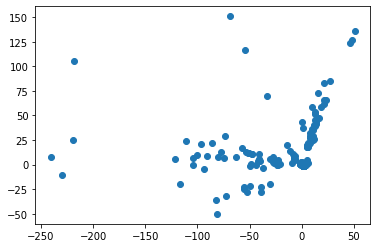

In [31]:
from matplotlib import pyplot as plt

zt = z.cpu().detach().numpy()

plt.scatter(zt[:,0], zt[:,1])

In [37]:
from datetime import datetime
import os

# save model and include timestamp
def save_model(model, optimizer, loss_hist, path):
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
        
    full_path = f"checkpoints/{path}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_hist': loss_hist
    }, full_path)
    print(f"Model saved to {full_path}.")

def load_model(path, model_type, model_params, dev):
    # check if path is a full path or just a filename
    if not os.path.exists(path):
        path = f"checkpoints/{path}"
    checkpoint = torch.load(path)
    # create model based on model_type
    if model_type == "gmvae":
        model = GMVAE(**model_params).to(dev)
    elif model_type == "vae":
        model = VAE(**model_params).to(dev)
    else:
        raise ValueError("Model type not recognized.")   

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_hist = checkpoint['loss_hist']
    return model, optimizer, loss_hist

# save_model(gm, gm_opt, gm_loss_hist, path="gmvae")
# save_model(vae, vae_opt, vae_loss_hist, path="vae")

# gm2, gm_opt, gm_loss_hist2 = load_model("gmvae_20230221_014308.pt", "gmvae", {"input_dim": 2766, "latent_dim": 2, "num_clusters": 5}, dev)
# vae2, vae_opt, vae_loss_hist2 = load_model("vae_20230221_014308.pt", "vae", {"input_dim": 2766, "latent_dim": 2}, dev)

## Gene "correlation" matrix C

In [42]:
from functorch import jacfwd, vmap

def jac(f, z):
    # composed with vmap for batched Jacobians
    return vmap(jacfwd(f))(z)
    
def jac_robust(f, z):
    # alternative jac if experiencing crashes 
    batch_size, z_dim = z.size()
    v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
    z = z.repeat(1, z_dim).view(-1, z_dim)
    return torch.autograd.functional.jvp(f, z, v=v)[1].view(batch_size, z_dim, -1).permute(0, 2, 1)

# gene "correlation" matrix C
def C_matrix(f, z, normalize=False):
    '''
    f:      model.decode: (b, m) -> (b, n) 
    z:      torch.tensor whose size = (b, m) (keep b low for memory)
    out:    torch.tensor whose size = (b, n, n)
    '''
    J = jac(f, z)

    # J @ J.T on batch 
    if normalize:
        return torch.bmm(J, J.transpose(1,2)) / J.norm(p=2, dim=2).unsqueeze(-1)
    else:
        return torch.bmm(J, J.transpose(1,2))

# jacrev: 1.45s
# jacfwd: 80-90ms 
# jvp:    85-92ms 

In [41]:
# directly on gradients 

# z = model.reparameterize(*model.encoder(test))
# for i in range(z.shape[1]):
#     model.decoder.zero_grad()
#     leaf = z[0].detach().requires_grad_()
#     out = model.decoder(z[0])[i]
#     out.retain_grad() 
#     out.backward(retain_graph=True)
#     gene_gradients.append(out.grad.clone().detach())
# G = torch.stack(gene_gradients)


# Geodesics

In [43]:
def get_Riemannian_metric(f, z): #J.T @ J instead! 
    '''
    f:      model.decode: function (b, m) -> (b, n)
    z:      torch.tensor whose size = (b, m)
    out:    torch.tensor whose size = (b, n, n)
    Outputs the Riemannian metric on the manifold of gene expression vectors
    '''
    J = jac_robust(f, z)
    out = torch.einsum('nij,nik->njk', J, J)
    return out

In [44]:
def compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric):
    '''
    curve:  torch.tensor whose size = (L, d)
    out:    torch.tensor whose size = (1)
    '''
    dt = 1/(len(curve)-1)
    velocity = (curve[:-1] - curve[1:])/dt # (L-1, d)
    G = get_Riemannian_metric(pretrained_model.decode, curve[:-1]) # (L-1, d, d)
    out = torch.sqrt(torch.einsum('ni, nij, nj -> n', velocity, G, velocity)).sum() * dt # int(sqrt(velocity.T @ G @ velocity)) dt
    return out


In [55]:
# compute the length of two crossing curves in latent space ( X )
curve1 = torch.tensor([[-2, -2], [-1.5, -1.5], [-1, -1], [-0.5, -0.5], [0, 0], [0.5, 0.5], [1, 1], [1.5, 1.5], [2, 2]]).to(dev)
curve2 = torch.tensor([[-2, 2], [-1.5, 1.5], [-1, 1], [-0.5, 0.5], [0, 0], [0.5, -0.5], [1, -1], [1.5, -1.5], [2, -2]]).to(dev)

vae_len1 = compute_length_of_curve(curve1, vae, get_Riemannian_metric).item()
vae_len2 = compute_length_of_curve(curve2, vae, get_Riemannian_metric).item()

gm_len1 = compute_length_of_curve(curve1, gm, get_Riemannian_metric).item()
gm_len2 = compute_length_of_curve(curve2, gm, get_Riemannian_metric).item()

print("  VAE: %f, %f" % (vae_len1, vae_len2))
print("GMVAE: %f, %f" % (gm_len1, gm_len2))

  VAE: 336.583252, 456.003662
GMVAE: 162.408325, 130.855530


### BFGS optimizer to minimize geodesic 

In [ ]:
def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    from scipy.optimize import minimize
    class GeodesicFittingTool():
        def __init__(self, z1, z2, z_init, pretrained_model, get_Riemannian_metric, num_discretization, method, device=f"cuda:{0}"):
            self.z1 = z1
            self.z2 = z2
            self.pretrained_model = pretrained_model
            self.get_Riemannian_metric = get_Riemannian_metric
            self.num_discretization = num_discretization
            self.delta_t = 1/(num_discretization-1)
            self.device = device
            self.method = method
            self.z_init_input = z_init
            self.initialize()
            
        def initialize(self):
            self.z_init= self.z1.squeeze(0)
            self.z_final= self.z2.squeeze(0)
            dim = self.z_final.size(0)
            self.init_z = self.z_init_input.detach().cpu().numpy()
            self.z_shape = self.init_z.shape
            self.init_z_vec = self.init_z.flatten()

        def geodesic_loss(self, z): 
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1])
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            return loss.item()
        
        def jac(self, z):
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_torch.requires_grad = True
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1], create_graph=True)
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            loss.backward()
            z_grad = z_torch.grad
            return z_grad.detach().cpu().numpy().flatten()

        def callback(self, z):
            self.Nfeval += 1
            return print('{} th loss : {}'.format(self.Nfeval, self.geodesic_loss(z)))
            
        def BFGS_optimizer(self, callback=False, maxiter=1000):
            self.Nfeval = 0
            z0 = self.init_z_vec
            if callback == True:
                call = self.callback
            else:
                call = None
            res = minimize(
                self.geodesic_loss, 
                z0, 
                callback=call, 
                method=self.method,
                jac = self.jac,
                options = {
                    'gtol': 1e-10, 
                    'eps': 1.4901161193847656e-08, 
                    'maxiter': maxiter, 
                    'disp': True, 
                    'return_all': False, 
                    'finite_diff_rel_step': None}
                )
            self.res = res

    z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    
    tool = GeodesicFittingTool(z1, z2, z12_linear_curve[1:-1], pretrained_model, get_Riemannian_metric, num_discretization, 'BFGS', device=device)
    tool.BFGS_optimizer()
    z_torch = torch.tensor(tool.res['x'].reshape(tool.z_shape), dtype=torch.float32).to(device)
    out = torch.cat([tool.z_init.unsqueeze(0), z_torch, tool.z_final.unsqueeze(0)], dim=0)
    return out


In [ ]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])


In [ ]:
L12 = compute_length_of_curve(
    z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
L12


In [ ]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()
